In [10]:
import json
import torch, re, os, cv2
from collections import defaultdict
from cv2.typing import MatLike
import matplotlib.pyplot as plt
import numpy as np

def load_camera_matrices(path, matrix_types=None):
    """
    Loads camera matrices from .npy files in the specified directory.

    Parameters:
        path (str): Path to the directory containing camera matrix files.
        matrix_types (set or list, optional): Specifies which matrix types to load (e.g., {'K', 'RT'}).
        If None, all available matrices ('K', 'RT', 'P') will be loaded.

    Returns:
        dict: A dictionary mapping camera numbers to their respective matrices.
    """
    cameras = defaultdict(dict)
    file_pattern = re.compile(r"^Camera_(\d+)_(K|RT|P)\.npy$")
    
    if matrix_types is not None:
        matrix_types = set(matrix_types)  # Ensure it's a set for quick lookup
    
    for filename in sorted(os.listdir(path)):  # Sort filenames alphabetically
        match = file_pattern.match(filename)
        if match:
            cam_number, matrix_type = match.groups()
            cam_number = int(cam_number)  # Convert camera number to integer
            if matrix_types is None or matrix_type in matrix_types:
                filepath = os.path.join(path, filename)
                cameras[cam_number][matrix_type] = torch.tensor(np.load(filepath))
    
    return cameras

def load_renders(renders_path):
    renders = defaultdict(dict)
    pattern = re.compile(r"([a-zA-Z]+)(\d+)\.png")
    for filename in sorted(os.listdir(renders_path), key=lambda x: (re.match(pattern, x).group(1), int(re.match(pattern, x).group(2))) if re.match(pattern, x) else (x, float('inf'))):
        match = pattern.match(filename)
        if match:
            word, number = match.groups()
            number = int(number)  # Convert number to integer for sorting

            image_path = os.path.join(renders_path, filename)
            image = cv2.imread(image_path)  # Load image using OpenCV
            if image is not None:
                renders[word][number] = image  # Store image in the nested dictionary

    return renders

def get_projmats_and_edgemap_info(view_idx, target_mesh: str, matrices, edgemaps, edgemaps_len):
    """
    Retrieves the projection matrices and target edgemap information for the specified view indices and target mesh.

    Parameters:
        view_idx (list): List of indices for which to retrieve projection matrices and edgemaps.
        target_mesh (str): The target mesh name (e.g., 'balloon') to extract edgemaps and lengths for.
        matrices (dict): Dictionary containing camera matrices.
        edgemaps (dict): Dictionary containing edgemaps for various meshes.
        edgemaps_len (dict): Dictionary containing the lengths of the edgemaps for each mesh.

    Returns:
        tuple: A tuple containing the projection matrices (torch.Tensor) and the target edgemap information (tuple of torch.Tensors).
    """
    # Get the projection matrices for the specified view indices
    projmats = torch.stack([matrices[view_idx[i]]["P"] for i in range(len(view_idx))])

    # Get the target edgemaps for the specified target mesh
    tgt_edgemaps = torch.nn.utils.rnn.pad_sequence([edgemaps[target_mesh][i] for i in view_idx], batch_first=True, padding_value=0.0)
    tgt_edgemaps_len = torch.tensor([edgemaps_len[target_mesh][i] for i in view_idx])

    # Pack the target edgemaps and their lengths
    tgt_edgemap_info = (tgt_edgemaps, tgt_edgemaps_len)

    return projmats, tgt_edgemap_info

def canny_edge_map(img: MatLike, options):
    equalise, t1, t2 = options
    # convert to grayscale
    img_greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if equalise:
        img_greyscale = cv2.equalizeHist(img_greyscale)
    # apply edge detection
    # edge_map = cv2.Canny(img_greyscale, threshold1=20, threshold2=100)
    # edge_map = cv2.Canny(img_greyscale, threshold1=15, threshold2=250)
    edge_map = cv2.Canny(img_greyscale, threshold1=t1, threshold2=t2)
    # return edge map
    return edge_map


def visualize_edges(renders, edgemap_options, target_mesh):
    num_views = 12  # assuming 12 views per mesh
    rows, cols = 6, 2
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

    mesh_renders = renders.get(target_mesh, {})
    mesh_options = edgemap_options.get(target_mesh, {})

    for view_idx in range(num_views):
        row, col = divmod(view_idx, cols)
        ax = axes[row, col]

        img = mesh_renders.get(view_idx)
        if img is not None and str(view_idx) in mesh_options:
            edge_option = mesh_options[str(view_idx)]
            edges = canny_edge_map(img, edge_option)
            ax.imshow(edges, cmap='gray')
        else:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)

        ax.set_title(f"View {view_idx}")
        ax.axis('off')

    plt.suptitle(f"Canny edges for mesh: {target_mesh}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Load configuration from JSON file
with open("/Users/jeffreyliang/Documents/Honours/honours/src/experiments/skyconfig_local.json", "r") as f:
    cfg = json.load(f)

mesh_dir = cfg["paths"]["mesh_dir"]
mesh_res = cfg["paths"]["mesh_res"]
renders_path = cfg["paths"]["renders_path"]
matrices_path = cfg["paths"]["matrices_path"]

# Fix edgemap_options to be a dictionary where keys are mesh names and values are dictionaries of view indices
edgemap_options = {mesh["name"]: {str(k): v for k, v in mesh["edgemap_options"].items()} for mesh in cfg["meshes"]}

# Load renders and camera matrices
renders = load_renders(renders_path)
matrices = load_camera_matrices(matrices_path)


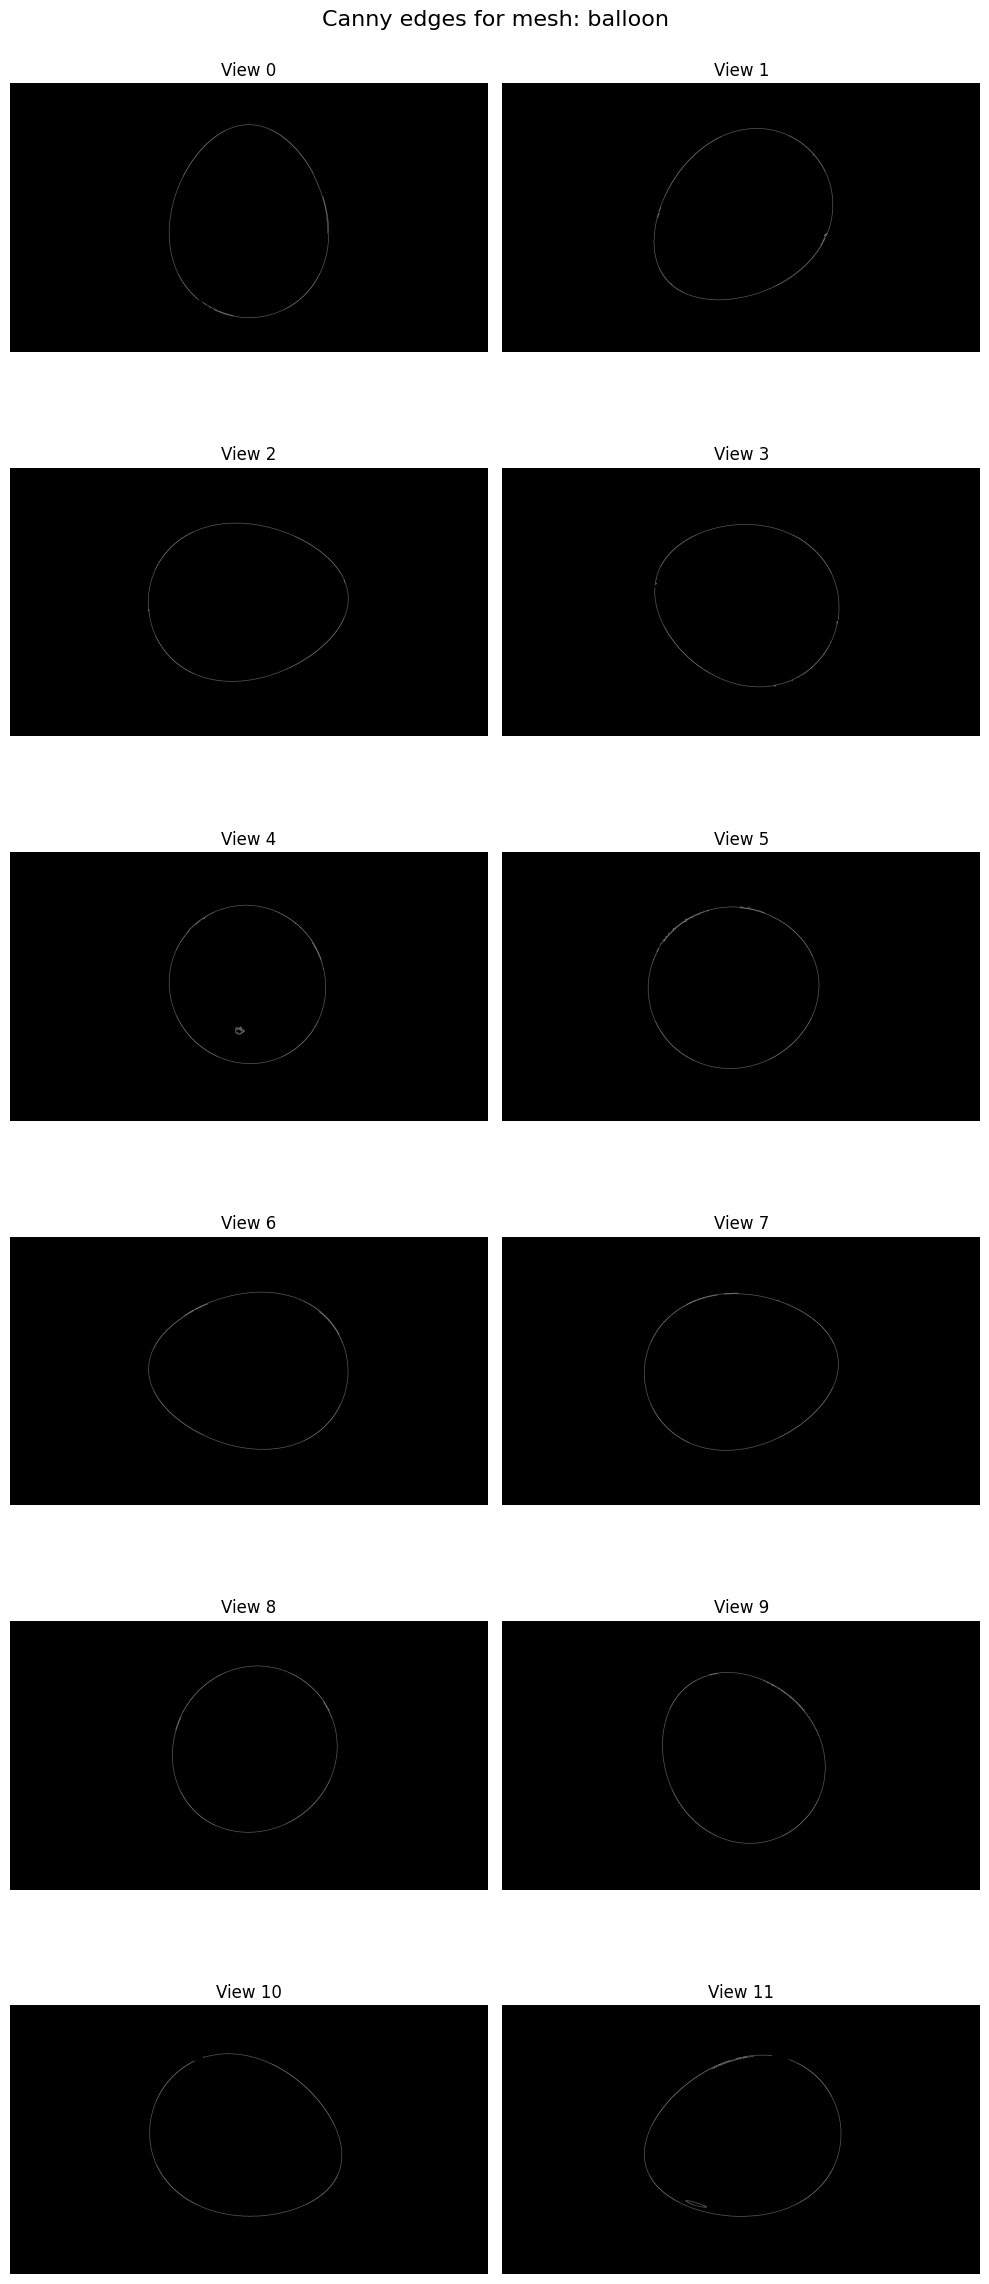

In [11]:
visualize_edges(renders, edgemap_options, target_mesh="balloon")